In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [83]:
df = pd.read_csv("C:/Users/oscar/Downloads/Big5raw.csv")
df_paises = pd.read_excel("C:/Users/oscar/Downloads/Listado ISO.xlsx")
valid_countries = df_paises['Alpha-2 code'].dropna().unique()

In [ ]:
invalid_countries = df[~df['country'].isin(valid_countries)]

# Mostrar los paísesv
print("Países no válidos en df:")
print(invalid_countries[['country']].drop_duplicates())
num_invalid_countries = invalid_countries.shape[0]
print(f"\nNúmero de países no válidos: {num_invalid_countries}")

Países no válidos en df:
      country
308       (nu
365       NaN
1542       A1
3367       EU
6005       A2
9714       AP
16417     USS

Número de países no válidos: 442


In [ ]:
df.loc[df["age"] > 1000, "age"] = 2012 - df["age"]
df["country"] = df["country"].replace("USS", "US")
df["country"] = df["country"].replace("EU", "US")
valid_countries = df_paises['Alpha-2 code'].dropna().unique()  # Extraer los códigos Alpha-2

df = df[df['country'].isin(valid_countries)]
print(f"\nNúmero total de registros después de eliminar los países no válidos: {df.shape[0]}")


Número total de registros después de eliminar los países no válidos: 19303


In [ ]:
# Paso 1: Eliminar casos con valores 0, 0.0 y nulos (NaN) en los atributos
deleted_1 = df[(df == 0) | (df == 0.0) | df.isna()].shape[0]
df_step_1 = df.copy()  # Hacemos una copia del df para no modificar el original al calcular eliminados
df = df.replace([0, 0.0], pd.NA)  # Reemplazar 0 y 0.0 por NaN
df = df.dropna()  # Eliminar filas con NaN

# Paso 2: Eliminar casos con edades mayores a 68
deleted_2 = df[df["age"] > 68].shape[0]
df = df[df["age"] <= 68]

# Paso 3: Eliminar casos con códigos de países inválidos (NaN o "(nu)")
deleted_3 = df[df["country"].isin([pd.NA, "(nu"])].shape[0]
df = df[~df["country"].isin([pd.NA, "(nu"])]

# Paso 4: Eliminar cualquier caso con valores faltantes en las variables demográficas
deleted_4 = df[df[["age", "gender", "country"]].isna().any(axis=1)].shape[0]
df = df.dropna(subset=["age", "gender", "country"])

deleted_records = {
    "Eliminados en Paso 1 (valores 0, 0.0, nulos)": deleted_1,
    "Eliminados en Paso 2 (edad > 68)": deleted_2,
    "Eliminados en Paso 3 (país inválido)": deleted_3,
    "Eliminados en Paso 4 (valores faltantes en demográficas)": deleted_4,
    "Registros finales": len(df)
}

for key, value in deleted_records.items():
    print(f"{key}: {value}")

Eliminados en Paso 1 (valores 0, 0.0, nulos): 19303
Eliminados en Paso 2 (edad > 68): 72
Eliminados en Paso 3 (país inválido): 0
Eliminados en Paso 4 (valores faltantes en demográficas): 0
Registros finales: 18896


In [ ]:
personality_columns = [
    'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10',
    'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10',
    'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
    'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10',
    'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8', 'O9', 'O10'
]

personality_var = df[personality_columns].var()
top_5_personality = personality_var.sort_values(ascending=False).head(5)

print("Top 5 variables de personalidad más representativas (por varianza):")
print(top_5_personality)

Top 5 variables de personalidad más representativas (por varianza):
E7    2.048538
C6     1.95573
E9     1.95087
A1    1.875966
C2    1.866917
dtype: object


Las 5 variables de personalidad más representativas, basadas en la varianza, son:

E7: "I talk to a lot of different people at parties." (Varianza = 2.048391)
C6: "I often forget to put things back in their proper place." (Varianza = 1.956031)
E9: "I don't mind being the center of attention." (Varianza = 1.95034)
A1: "I feel little concern for others." (Varianza = 1.876664)
C2: "I leave my belongings around." (Varianza = 1.867885)

Justificación:
Estas variables tienen la mayor dispersión entre las respuestas de los participantes, lo que sugiere que son las que mejor diferencian las características de personalidad en este conjunto de datos. En otras palabras, los participantes ofrecen respuestas más variadas a estas preguntas, lo que las convierte en buenos predictores o representaciones de las diferencias de personalidad.

Por ejemplo, variables como E7 y E9 están relacionadas con la extroversión, lo que indica que los participantes tienen diferentes grados de sociabilidad y de comodidad al estar en el centro de atención. Por otro lado, C6 y C2 están relacionadas con la conciencia, mostrando variabilidad en la organización y el cuidado con los detalles. A1, que mide la empatía, también refleja una gran variabilidad, lo que sugiere que las personas tienen diferentes niveles de preocupación por los demás

In [ ]:
# Seleccionar solo las columnas de personalidad
df_personality = df[personality_columns]

# Estándarizar las variables (PCA es sensible a la escala de los datos)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_personality)


In [89]:
# Crear el modelo PCA
pca = PCA()

# Ajustar el modelo PCA a los datos escalados
pca.fit(df_scaled)

# Ver la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Mostrar la varianza acumulada
cumulative_variance = explained_variance.cumsum()

# Mostrar el porcentaje de varianza explicada por cada componente
for i, var in enumerate(cumulative_variance):
    print(f"Componente {i+1}: {var*100:.2f}%")


Componente 1: 16.06%
Componente 2: 25.30%
Componente 3: 32.82%
Componente 4: 39.92%
Componente 5: 45.45%
Componente 6: 48.58%
Componente 7: 51.25%
Componente 8: 53.35%
Componente 9: 55.29%
Componente 10: 57.14%
Componente 11: 58.93%
Componente 12: 60.67%
Componente 13: 62.36%
Componente 14: 63.96%
Componente 15: 65.54%
Componente 16: 67.01%
Componente 17: 68.47%
Componente 18: 69.91%
Componente 19: 71.27%
Componente 20: 72.60%
Componente 21: 73.91%
Componente 22: 75.18%
Componente 23: 76.41%
Componente 24: 77.59%
Componente 25: 78.76%
Componente 26: 79.89%
Componente 27: 81.00%
Componente 28: 82.07%
Componente 29: 83.11%
Componente 30: 84.13%
Componente 31: 85.14%
Componente 32: 86.13%
Componente 33: 87.10%
Componente 34: 88.07%
Componente 35: 88.97%
Componente 36: 89.86%
Componente 37: 90.73%
Componente 38: 91.57%
Componente 39: 92.41%
Componente 40: 93.22%
Componente 41: 94.01%
Componente 42: 94.77%
Componente 43: 95.52%
Componente 44: 96.25%
Componente 45: 96.94%
Componente 46: 97.6

In [90]:
# Encontrar el número de componentes que explican el 90% de la varianza
components_needed = (cumulative_variance >= 0.90).argmax() + 1
print(f"Se necesitan {components_needed} componentes para representar el 90% de los datos.")


Se necesitan 37 componentes para representar el 90% de los datos.


In [ ]:
# Ver la importancia de cada variable en cada componente
component_importance = pd.DataFrame(pca.components_, columns=personality_columns)
component_importance.head(3)



,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,O1,O2,O3,O4,O5,O6,O7,O8,O9,O10
0,-0.184079,0.180015,-0.250917,0.206253,-0.232007,0.198112,-0.221088,0.133185,-0.164691,0.201623,...,-0.069581,0.099313,-0.035675,0.072519,-0.130208,0.087332,-0.111727,-0.012819,0.003720,-0.117102
1,-0.128194,0.166950,-0.072901,0.094944,-0.148321,0.127626,-0.136392,0.107972,-0.115835,0.074984,...,-0.013612,-0.029603,-0.108852,0.026210,-0.021431,0.061567,0.038150,-0.045015,-0.090200,-0.069439
2,0.156285,-0.143573,0.066179,-0.168613,0.088599,-0.103011,0.126811,-0.191013,0.176447,-0.159581,...,0.023904,-0.033000,0.019030,-0.007955,0.023799,-0.028569,-0.019995,0.057561,-0.130208,0.042388


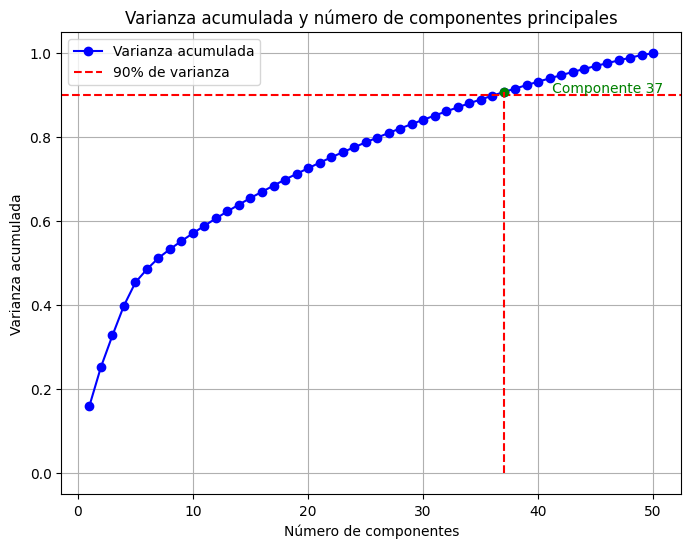

Se necesitan 37 componentes para explicar el 90% de la varianza.


In [ ]:
explained_variance = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b', label='Varianza acumulada')

plt.axhline(y=0.90, color='r', linestyle='--', label="90% de varianza")

num_components_90 = np.argmax(cumulative_variance >= 0.90) + 1


plt.plot(num_components_90, cumulative_variance[num_components_90 - 1], 'go')  # Marcamos el punto en rojo
plt.text(num_components_90, cumulative_variance[num_components_90 - 1], f'           Componente {num_components_90}', color='green')
plt.plot([num_components_90, num_components_90], [0, cumulative_variance[num_components_90 - 1]], 'r--')

plt.title('Varianza acumulada y número de componentes principales')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.legend(loc='best')
plt.grid(True)

plt.show()
print(f"Se necesitan {num_components_90} componentes para explicar el 90% de la varianza.")


In [ ]:

loadings = pca.components_
component_1_loadings = loadings[0]  # Cargas para el primer componente
top_5_variables_component_1 = np.argsort(np.abs(component_1_loadings))[-5:]

# Ver que shoow
print("Top 5 variables representativas para el primer componente:")
for idx in top_5_variables_component_1:
    print(personality_columns[idx], component_1_loadings[idx])


Top 5 variables representativas para el primer componente:
E10 0.201622981017934
E4 0.20625332210938416
E7 -0.22108828428977378
E5 -0.23200698773861217
E3 -0.2509172187409806
